In [2]:
path_full_summarized_table = "../datasets/2023-01-01_benchmark_processed_data/2023-01-27_FullTableAurocFiltered.tsv"
path_config_viz = "../config/visualization.yaml"
path_output_dir = "./"
export_plots = False


# Forewords

Exploration of the differences in performance of models using sequence only as an input feature
and models using both sequence and structure.


Steps : 
- for each method + dataset + negative set: rank the auROCs.
- for each dataset + negative set: calculate the average rank per model
- plot the avg_rank_seq vs avg_rank_seq+struct ; spot those which show large deviation.
- check how these behave in the difference of auroc between neg1 and neg2.

# Imports and definitions

/home/lambertmoy/projects/Benchmark-RBP/analyses/code/figure_layouts.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


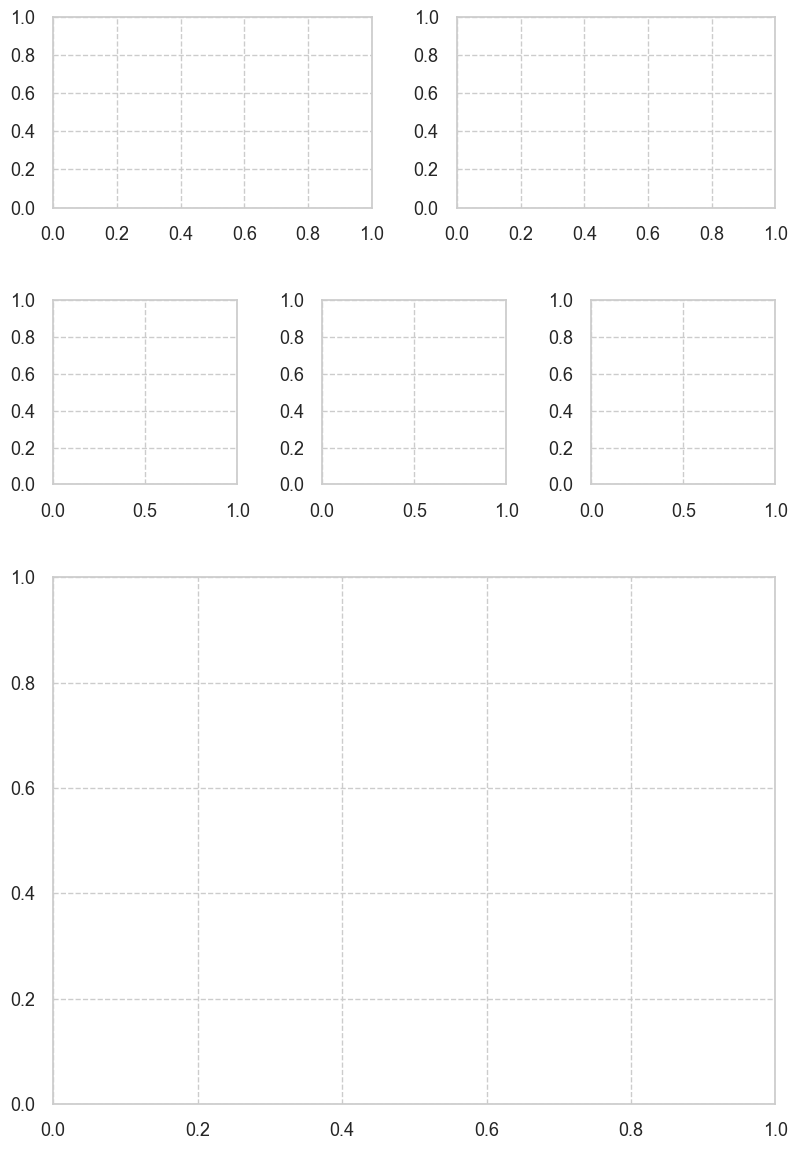

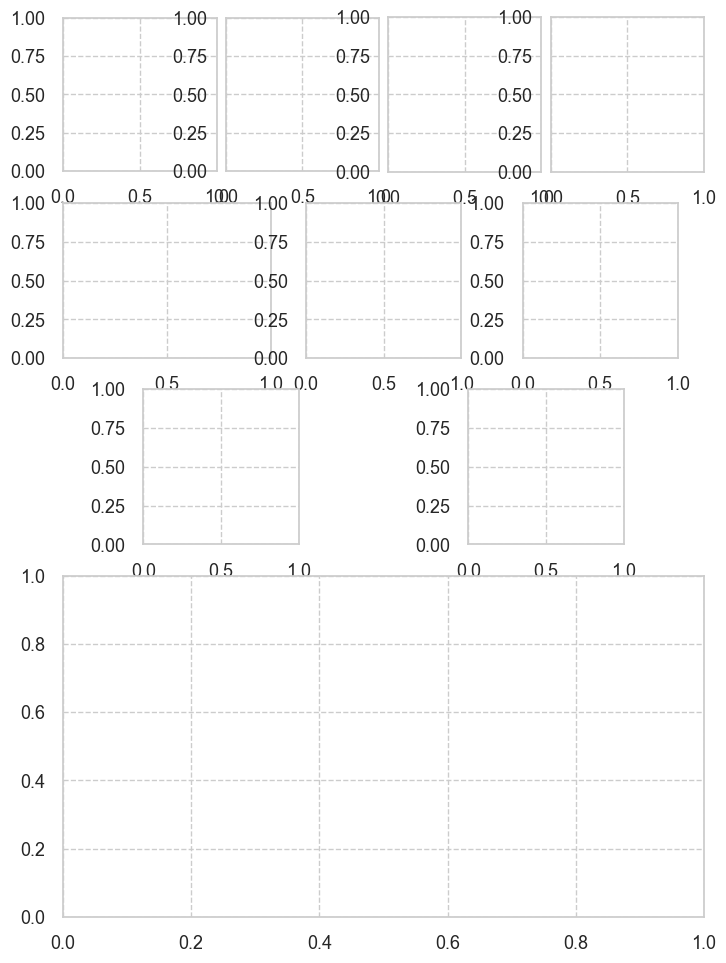

In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml
import scipy.stats

from dotmap import DotMap


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

# Load 

## Data 

In [4]:
full_summarized_table = pd.read_csv(
    path_full_summarized_table, sep="\t", header=0, index_col=None
)


## Config

In [3]:
with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)


In [5]:
DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]


In [6]:
sequence_only = [
    "Pysster-101",  # Pysster-101 is closer to the perf of other methods; using it should remove the input-length favorable bias.
    "DeepCLIP",
    "DeepRAM",
    # BERT-RBP, # Excluded given the poor results.
]
sequence_structure = ["PRISMNet", "iDeepS"]

map_method_to_inputfeat = {
    **{k: "seq" for k in sequence_only},
    **{k: "seq+struct" for k in sequence_structure},
}


In [7]:
# We will look at the top 10% models with greater auROC from seq+struct compared to seq-only
QUANTILE_THRESHOLD = 0.9


# Prepare and explore tables

## Prepare

In [8]:
def get_data_prismnet():
    tmp_inputfeat = (
        full_summarized_table.loc[
            lambda df: df["arch"].isin(
                sequence_only
                + [
                    "PRISMNet",
                ]
            ),
            :,
        ]
        .copy()
        .assign(arch_inputtype=lambda df: df["arch"].map(map_method_to_inputfeat.get))
    )

    tmp_inputfeat_n1 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-1", :
    ]
    tmp_inputfeat_n2 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-2", :
    ]
    # ALTERNATIVE : DIRECTLY WORK WITH AUROCs
    # The "rank" approach is difficult to grasp ; check if results are really different when taking
    # the average auROC.

    tmp_inputfeat_n1_piv_ALT = tmp_inputfeat_n1.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n1_piv_ALT["delta"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    )

    tmp_inputfeat_n1_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ).quantile(
        QUANTILE_THRESHOLD
    )

    tmp_inputfeat_n2_piv_ALT = tmp_inputfeat_n2.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n2_piv_ALT["delta"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ).quantile(
        QUANTILE_THRESHOLD
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile_n1"] = (
        tmp_inputfeat_n2_piv_ALT["RBP_dataset"]
        .isin(
            tmp_inputfeat_n1_piv_ALT.loc[
                tmp_inputfeat_n1_piv_ALT["is_top_decile"], "RBP_dataset"
            ].values
        )
        .values
    )

    return tmp_inputfeat_n1_piv_ALT, tmp_inputfeat_n2_piv_ALT


In [9]:
def get_data_ideeps():
    tmp_inputfeat = (
        full_summarized_table.loc[
            lambda df: df["arch"].isin(
                sequence_only
                + [
                    "iDeepS",
                ]
            ),
            :,
        ]
        .copy()
        .assign(arch_inputtype=lambda df: df["arch"].map(map_method_to_inputfeat.get))
    )

    tmp_inputfeat_n1 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-1", :
    ]
    tmp_inputfeat_n2 = tmp_inputfeat.loc[
        lambda df: df["model_negativeset"] == "negative-2", :
    ]
    # ALTERNATIVE : DIRECTLY WORK WITH AUROCs
    # The "rank" approach is difficult to grasp ; check if results are really different when taking
    # the average auROC.

    tmp_inputfeat_n1_piv_ALT = tmp_inputfeat_n1.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n1_piv_ALT["delta"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    )

    tmp_inputfeat_n1_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n1_piv_ALT["seq+struct"] - tmp_inputfeat_n1_piv_ALT["seq"]
    ).quantile(
        QUANTILE_THRESHOLD
    )

    tmp_inputfeat_n2_piv_ALT = tmp_inputfeat_n2.pivot_table(
        index=["dataset", "RBP_dataset"],
        columns=["arch_inputtype"],
        values="auroc",
        aggfunc=np.mean,
    ).reset_index()

    tmp_inputfeat_n2_piv_ALT["delta"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile"] = (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ) > (
        tmp_inputfeat_n2_piv_ALT["seq+struct"] - tmp_inputfeat_n2_piv_ALT["seq"]
    ).quantile(
        QUANTILE_THRESHOLD
    )

    tmp_inputfeat_n2_piv_ALT["is_top_decile_n1"] = (
        tmp_inputfeat_n2_piv_ALT["RBP_dataset"]
        .isin(
            tmp_inputfeat_n1_piv_ALT.loc[
                tmp_inputfeat_n1_piv_ALT["is_top_decile"], "RBP_dataset"
            ].values
        )
        .values
    )

    return tmp_inputfeat_n1_piv_ALT, tmp_inputfeat_n2_piv_ALT


In [10]:
(ideeps_tmp_inputfeat_n1_piv_ALT, ideeps_tmp_inputfeat_n2_piv_ALT) = get_data_ideeps()
(
    prismnet_tmp_inputfeat_n1_piv_ALT,
    prismnet_tmp_inputfeat_n2_piv_ALT,
) = get_data_prismnet()


## Explore 

### Number of models, models with largest delta auROCs

In [11]:
print(
    ideeps_tmp_inputfeat_n1_piv_ALT.shape[0], prismnet_tmp_inputfeat_n1_piv_ALT.shape[0]
)


302 302


In [12]:
ideeps_rbps = set(
    ideeps_tmp_inputfeat_n1_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
prismnet_rbps = set(
    prismnet_tmp_inputfeat_n1_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)


In [13]:
print(len(prismnet_rbps))
print(len(ideeps_rbps))


31
31


In [14]:
print(
    (
        "Number of models in the top10% of delta(auROC_seq+struct,auROC_seq)\n "
        "found in both `PrismNet vs seq-only` and `iDeepS vs seq-only` :"
        f"{len(prismnet_rbps & ideeps_rbps)}"
    )
)


Number of models in the top10% of delta(auROC_seq+struct,auROC_seq)
 found in both `PrismNet vs seq-only` and `iDeepS vs seq-only` :13


For paper: selected "EWSR1", "PUS1", "CAPRIN1".

In [15]:
display(prismnet_rbps & ideeps_rbps)


{'ABCF1_K562',
 'AKAP1_K562',
 'Ago2_UNKNOWN_HITSCLIP_4',
 'CAPRIN1_HEK293_PARCLIP',
 'CPEB4_K562',
 'DICER1_HEK293_PARCLIP',
 'EWSR1_HEK293_PARCLIP',
 'G45_HEK293_PARCLIP',
 'PUS1_K562',
 'QKI_HEK293_PARCLIP',
 'SUPV3L1_K562',
 'UPF1_HEK293_PARCLIP',
 'ZC3H11A_K562'}

In [16]:
prismnet_tmp_inputfeat_n1_piv_ALT.loc[
    lambda df: df["RBP_dataset"].isin(prismnet_rbps & ideeps_rbps), :
].sort_values(by="delta", ascending=False)


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile
180,ENCODE,SUPV3L1_K562,0.754856,0.890727,0.135871,True
6,ENCODE,AKAP1_K562,0.769056,0.889051,0.119996,True
2,ENCODE,ABCF1_K562,0.816998,0.922625,0.105627,True
229,Mukherjee-PAR-CLIP,DICER1_HEK293_PARCLIP,0.735108,0.834146,0.099038,True
217,ENCODE,ZC3H11A_K562,0.757359,0.847297,0.089938,True
137,ENCODE,PUS1_K562,0.702508,0.792128,0.089620,True
244,Mukherjee-PAR-CLIP,G45_HEK293_PARCLIP,0.780200,0.867643,0.087442,True
16,ENCODE,CPEB4_K562,0.764860,0.851189,0.086329,True
260,Mukherjee-PAR-CLIP,QKI_HEK293_PARCLIP,0.881496,0.964527,0.083031,True
236,Mukherjee-PAR-CLIP,EWSR1_HEK293_PARCLIP,0.831268,0.911033,0.079764,True


In [17]:
ideeps_tmp_inputfeat_n1_piv_ALT.loc[
    lambda df: df["RBP_dataset"].isin(prismnet_rbps & ideeps_rbps), :
].sort_values(by="delta", ascending=False)


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile
236,Mukherjee-PAR-CLIP,EWSR1_HEK293_PARCLIP,0.831268,0.951273,0.120004,True
260,Mukherjee-PAR-CLIP,QKI_HEK293_PARCLIP,0.881496,0.983722,0.102227,True
226,Mukherjee-PAR-CLIP,CAPRIN1_HEK293_PARCLIP,0.768848,0.868386,0.099538,True
244,Mukherjee-PAR-CLIP,G45_HEK293_PARCLIP,0.780200,0.847299,0.067098,True
275,iONMF,Ago2_UNKNOWN_HITSCLIP_4,0.816784,0.880279,0.063495,True
268,Mukherjee-PAR-CLIP,UPF1_HEK293_PARCLIP,0.815025,0.878368,0.063343,True
229,Mukherjee-PAR-CLIP,DICER1_HEK293_PARCLIP,0.735108,0.794396,0.059288,True
137,ENCODE,PUS1_K562,0.702508,0.761681,0.059173,True
16,ENCODE,CPEB4_K562,0.764860,0.820679,0.055819,True
180,ENCODE,SUPV3L1_K562,0.754856,0.809689,0.054833,True


## Further exploration

### Q: are similar RBPs picked-up with both tools?

In [20]:
ideeps_rbps_n1 = set(
    ideeps_tmp_inputfeat_n1_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
prismnet_rbps_n1 = set(
    prismnet_tmp_inputfeat_n1_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
print(len(prismnet_rbps_n1 & ideeps_rbps_n1))


13


- In the negative-1 setting, we did see for both iDeepS and PrismNet a subset of RBP_CT_DATASET showing a great difference in performance when compared to the average seq-only perf.
- For illustration, the arbitrary top 10% of models was identified for each, corresponding to 31 models.
- We see here that 13 of these are in common.

To test this, in R: 

```
phyper(13, 31, 302-31, 31, lower.tail = F)
```

yields `0.00000005906184`

with `phyper(q,m,n,k)` where we are testing a "mark-recapture"-like situation,
i.e. from resampling `k` elements, we observe `q` elements "marked", from a set
of `m` marked elements mixed with a set of `n` unmarked elements.

In [114]:
1 - scipy.stats.hypergeom.cdf(k=13, M=302, n=31, N=31)


5.9061838642016085e-08

In [23]:
dict_hypergeom_test = dict(
    k=len(prismnet_rbps_n1 & ideeps_rbps_n1),
    M=ideeps_tmp_inputfeat_n1_piv_ALT.shape[0],
    n=ideeps_tmp_inputfeat_n1_piv_ALT["is_top_decile"].sum(),
    N=prismnet_tmp_inputfeat_n1_piv_ALT["is_top_decile"].sum(),
)
display(dict_hypergeom_test)
(1 - scipy.stats.hypergeom.cdf(**dict_hypergeom_test))


{'k': 13, 'M': 302, 'n': 31, 'N': 31}

5.9061838642016085e-08

In [24]:
ideeps_rbps_n2 = set(
    ideeps_tmp_inputfeat_n2_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
prismnet_rbps_n2 = set(
    prismnet_tmp_inputfeat_n2_piv_ALT.loc[
        lambda df: df["is_top_decile"], "RBP_dataset"
    ].values
)
print(len(prismnet_rbps_n2 & ideeps_rbps_n2))


10


In [25]:
dict_hypergeom_test = dict(
    k=len(prismnet_rbps_n2 & ideeps_rbps_n2),
    M=ideeps_tmp_inputfeat_n2_piv_ALT.shape[0],
    n=ideeps_tmp_inputfeat_n2_piv_ALT["is_top_decile"].sum(),
    N=prismnet_tmp_inputfeat_n2_piv_ALT["is_top_decile"].sum(),
)
display(dict_hypergeom_test)
(1 - scipy.stats.hypergeom.cdf(**dict_hypergeom_test))


{'k': 10, 'M': 302, 'n': 31, 'N': 31}

4.744505329412618e-05

### Q: for RBPs in common between datasets, are their rank in the delta-auROC comparable?

e.g. EWSR1: is in ENCODE (EWSR1_K562), PAR-CLIP (EWSR1_Hek293_PARCLIP), and iONMF.

⇒ for each dataset, is the associated model showing a greater rank than randomly
sampled models?


⇒ for iDeepS top 10% models, for the subset of which that are present in another dataset: are they showing greater ranks than random?


**not sensitive enough**: I will have very few RBPs left...

Suggestions:

- do the test of ranks at least on ENCODE models.
- correlation of ranks? (Kendall tau?, Spearman?)
- ???


In [55]:
# Illustration : EWSR1 is an RBP with models trained from all three datasets.
ideeps_tmp_inputfeat_n1_piv_ALT.loc[
    lambda df: df["RBP_dataset"].str.contains("EWSR1"), :
]


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile
47,ENCODE,EWSR1_K562,0.940670,0.948074,0.007404,False
236,Mukherjee-PAR-CLIP,EWSR1_HEK293_PARCLIP,0.831268,0.951273,0.120004,True
280,iONMF,EWSR1_UNKNOWN_PARCLIP_12,0.890265,0.893182,0.002916,False


#### Numbers of RBPs with more than one model

In [27]:
rbps = [
    rbp_ct_dataset.split("_")[0]
    for rbp_ct_dataset in full_summarized_table["RBP_dataset"].unique()
]
more_than_one_dataset = list(
    pd.Series(rbps).value_counts().loc[lambda v: v > 1].dropna().index.values
)


rbps_encode = [
    rbp_ct_dataset.split("_")[0]
    for rbp_ct_dataset in full_summarized_table["RBP_dataset"].unique()
    if (rbp_ct_dataset.endswith("K562") or rbp_ct_dataset.endswith("HepG2"))
]
rbps_both_ct_encode = list(
    pd.Series(rbps_encode).value_counts().loc[lambda v: v > 1].dropna().index.values
)

rbps_parclip = [
    rbp_ct_dataset.split("_")[0]
    for rbp_ct_dataset in full_summarized_table.loc[
        lambda df: df["dataset"].isin(["Mukherjee-PAR-CLIP"]), "RBP_dataset"
    ].unique()
]

rbps_parclip_encode = set(more_than_one_dataset) & set(rbps_parclip) & set(rbps_encode)


In [28]:
print(f"Number of RBPs with more than one datasets: {len(more_than_one_dataset)}")
print(
    f"Number of RBPs from ENCODE with both K562 and HepG2 models: {len(rbps_both_ct_encode)}"
)
print(f"Number of RBPs both in PAR-CLIP and ENCODE: {len(rbps_parclip_encode)}")


Number of RBPs with more than one datasets: 93
Number of RBPs from ENCODE with both K562 and HepG2 models: 73
Number of RBPs both in PAR-CLIP and ENCODE: 20


#### PAR-CLIP / ENCODE : agreement in delta auROC

#### Models from ENCODE HepG2 and K562 : agreement in delta auROC

In [35]:
def get_deltaauroc_agreement_encode(method, negative_set):
    if method not in ["ideeps", "prismnet"]:
        raise ValueError

    if negative_set not in ["negative-1", "negative-2"]:
        raise ValueError

    if method == "ideeps":
        if negative_set == "negative-1":
            source_table = ideeps_tmp_inputfeat_n1_piv_ALT
        else:
            source_table = ideeps_tmp_inputfeat_n2_piv_ALT
    else:
        if negative_set == "negative-1":
            source_table = prismnet_tmp_inputfeat_n1_piv_ALT
        else:
            source_table = prismnet_tmp_inputfeat_n2_piv_ALT

    source_table_w_ct_rbpname = []
    source_table_w_ct_rbpname.append(source_table)
    source_table_w_ct_rbpname.append(
        source_table["RBP_dataset"]
        .str.split("_", expand=True)
        .iloc[:, [0, 1]]
        .set_axis(["rbp_name", "ct"], axis=1, inplace=False)
    )
    source_table_w_ct_rbpname = pd.concat(source_table_w_ct_rbpname, axis=1)

    tmp_agreement_delta = source_table_w_ct_rbpname.loc[
        lambda df: (df["dataset"] == "ENCODE")
        & df["rbp_name"].isin(rbps_both_ct_encode),
        :,
    ].pivot_table(index="rbp_name", columns="ct", values="delta")

    return tmp_agreement_delta


tmp_agreement_encode_n1_delta_ideeps = get_deltaauroc_agreement_encode(
    "ideeps", "negative-1"
)
tmp_agreement_encode_n1_delta_prismnet = get_deltaauroc_agreement_encode(
    "prismnet", "negative-1"
)
tmp_agreement_encode_n2_delta_ideeps = get_deltaauroc_agreement_encode(
    "ideeps", "negative-2"
)
tmp_agreement_encode_n2_delta_prismnet = get_deltaauroc_agreement_encode(
    "prismnet", "negative-2"
)


/tmp/ipykernel_11973/4047439139.py:22: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  source_table['RBP_dataset'].str.split("_", expand=True
/tmp/ipykernel_11973/4047439139.py:22: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  source_table['RBP_dataset'].str.split("_", expand=True
/tmp/ipykernel_11973/4047439139.py:22: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  source_table['RBP_dataset'].str.split("_", expand=True
/tmp/ipykernel_11973/4047439139.py:22: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  source_table['RBP_dataset'].str.split("_", 

In [36]:
tmp_agreement_encode_n1_delta_ideeps.corr(method="spearman")


ct,HepG2,K562
ct,,
HepG2,1.000000,0.314945
K562,0.314945,1.000000


In [37]:
def plot_agreement_encode(
    table_agreement_delta_encode,
    method: str,
    negative_set: str,
    savefig_file: str = None,
):
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    sns.scatterplot(
        table_agreement_delta_encode,
        x="K562",
        y="HepG2",
        ax=ax1,
    )
    max_range = table_agreement_delta_encode.abs().max().max() * 1.1
    ax1.set_xlim(-max_range, max_range)
    ax1.set_ylim(-max_range, max_range)
    ax1.set_aspect("equal")

    spearmancorr = table_agreement_delta_encode.corr(method="spearman").iloc[0, 1]
    title = (
        f"delta-auROC {negative_set} ({method}, seq-only_avg),\n"
        f"for {len(rbps_both_ct_encode)} ENCODE RBPs found in both cell-lines\n"
        "(Spearman's rho = {:.3f})".format(spearmancorr)
    )

    ax1.set_title(title)
    plt.tight_layout()

    if savefig_file:
        plt.savefig(savefig_file)

    plt.show()


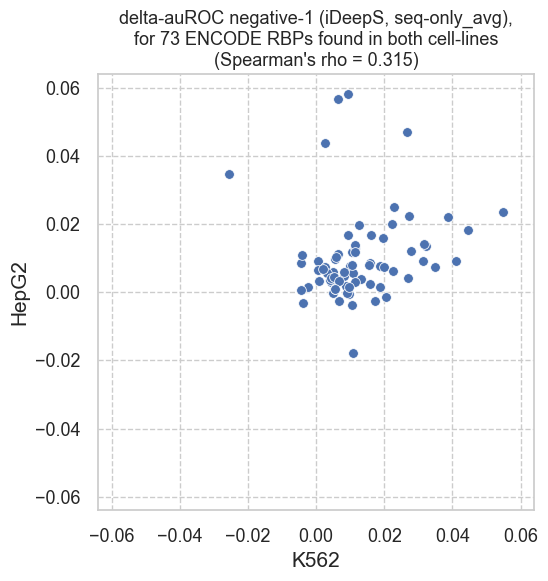

In [38]:
if export_plots:
    savefig_file = str(
        Path(path_output_dir) / "struct_vs_seq_only_ideeps_neg1_encode_ct.pdf"
    )
else:
    savefig_file = None

plot_agreement_encode(
    tmp_agreement_encode_n1_delta_ideeps,
    method="iDeepS",
    negative_set="negative-1",
    savefig_file=savefig_file,
)


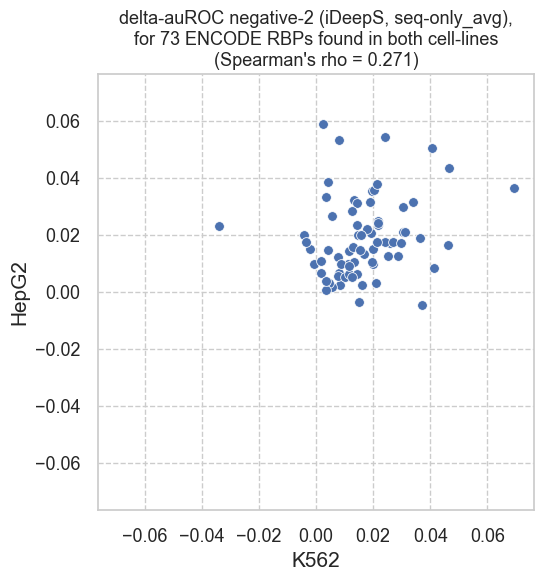

In [39]:
if export_plots:
    savefig_file = str(
        Path(path_output_dir) / "struct_vs_seq_only_ideeps_neg2_encode_ct.pdf"
    )
else:
    savefig_file = None

plot_agreement_encode(
    tmp_agreement_encode_n2_delta_ideeps,
    method="iDeepS",
    negative_set="negative-2",
    savefig_file=savefig_file,
)


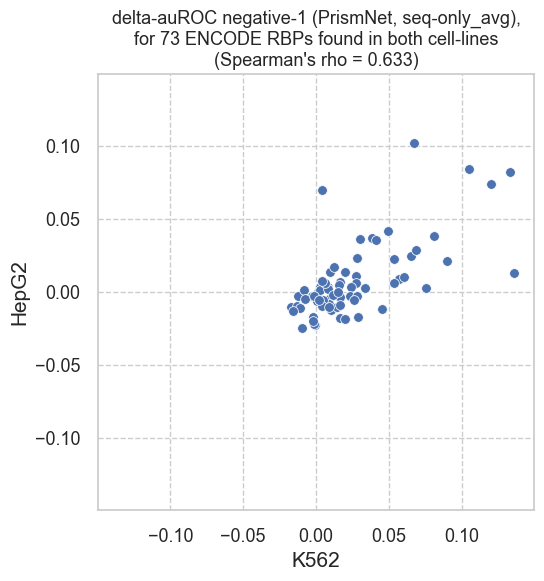

In [40]:
if export_plots:
    savefig_file = str(
        Path(path_output_dir) / "struct_vs_seq_only_prismnet_neg1_encode_ct.pdf"
    )
else:
    savefig_file = None

plot_agreement_encode(
    tmp_agreement_encode_n1_delta_prismnet,
    method="PrismNet",
    negative_set="negative-1",
    savefig_file=savefig_file,
)


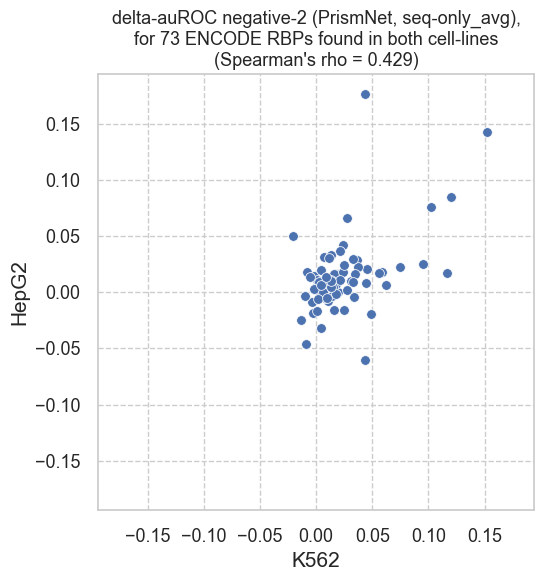

In [41]:
if export_plots:
    savefig_file = str(
        Path(path_output_dir) / "struct_vs_seq_only_prismnet_neg2_encode_ct.pdf"
    )
else:
    savefig_file = None

plot_agreement_encode(
    tmp_agreement_encode_n2_delta_prismnet,
    method="PrismNet",
    negative_set="negative-2",
    savefig_file=savefig_file,
)


### Q: structure-sensitive RBPs : are they consistent across datasets/cell types

- A subset of RBPs does show a contribution of structure even in the negative-2 setting. Very pronounced for PrismNet (see plot down in the notebook).

- Are the associated RBPs explored in multiple cell-types / protocols? Is the effect
consistent?

#### iDeepS

In [42]:
tmp_ideeps_struct_n2 = ideeps_tmp_inputfeat_n2_piv_ALT.copy()
tmp_ideeps_struct_n2["is_top_decile"] = tmp_ideeps_struct_n2[
    "delta"
] > tmp_ideeps_struct_n2["delta"].quantile(QUANTILE_THRESHOLD)


In [43]:
ideeps_subset_consistently_structure_benefitting = tmp_ideeps_struct_n2.loc[
    lambda df: (df["is_top_decile"]) & (df["is_top_decile_n1"]), :
].sort_values(by="RBP_dataset", ascending=False)

display(ideeps_subset_consistently_structure_benefitting)


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile,is_top_decile_n1
209,ENCODE,XRCC6_HepG2,0.758589,0.813124,0.054535,True,True
208,ENCODE,XPO5_HepG2,0.812345,0.862053,0.049708,True,True
268,Mukherjee-PAR-CLIP,UPF1_HEK293_PARCLIP,0.648971,0.729490,0.080519,True,True
184,ENCODE,TBRG4_HepG2,0.579329,0.638251,0.058922,True,True
266,Mukherjee-PAR-CLIP,TAF15_HEK293_PARCLIP,0.827315,0.882258,0.054943,True,True
137,ENCODE,PUS1_K562,0.601411,0.669919,0.068509,True,True
244,Mukherjee-PAR-CLIP,G45_HEK293_PARCLIP,0.747126,0.806852,0.059726,True,True
241,Mukherjee-PAR-CLIP,FXR1_HEK293_PARCLIP,0.730413,0.795186,0.064774,True,True
35,ENCODE,DGCR8_K562,0.679685,0.749204,0.069519,True,True
226,Mukherjee-PAR-CLIP,CAPRIN1_HEK293_PARCLIP,0.728386,0.777058,0.048672,True,True


In [44]:
print(ideeps_subset_consistently_structure_benefitting.shape[0])


11


In [49]:
dict_hypergeom_test = dict(
    k=ideeps_subset_consistently_structure_benefitting.shape[0],
    M=ideeps_tmp_inputfeat_n2_piv_ALT.shape[0],
    n=ideeps_tmp_inputfeat_n2_piv_ALT["is_top_decile_n1"].sum(),
    N=ideeps_tmp_inputfeat_n2_piv_ALT["is_top_decile"].sum(),
)

display(dict_hypergeom_test)
display((1 - scipy.stats.hypergeom.cdf(**dict_hypergeom_test)))


{'k': 11, 'M': 302, 'n': 31, 'N': 31}

6.1246357226929504e-06

6.1246357226929504e-06

#### PrismNet

In [52]:
tmp_prismnet_struct_n2 = prismnet_tmp_inputfeat_n2_piv_ALT.copy()
tmp_prismnet_struct_n2["is_top_decile"] = tmp_prismnet_struct_n2[
    "delta"
] > tmp_prismnet_struct_n2["delta"].quantile(QUANTILE_THRESHOLD)


In [53]:
prismnet_subset_consistently_structure_benefitting = tmp_prismnet_struct_n2.loc[
    lambda df: (df["is_top_decile"]) & (df["is_top_decile_n1"]), :
].sort_values(by="RBP_dataset", ascending=False)

display(prismnet_subset_consistently_structure_benefitting)


arch_inputtype,dataset,RBP_dataset,seq,seq+struct,delta,is_top_decile,is_top_decile_n1
218,ENCODE,ZC3H8_K562,0.663805,0.740686,0.076882,True,True
217,ENCODE,ZC3H11A_K562,0.679336,0.774084,0.094748,True,True
200,ENCODE,UPF1_K562,0.714282,0.834530,0.120248,True,True
199,ENCODE,UPF1_HepG2,0.754571,0.839490,0.084919,True,True
180,ENCODE,SUPV3L1_K562,0.701361,0.817993,0.116632,True,True
263,Mukherjee-PAR-CLIP,RTCB_HEK293_PARCLIP,0.755486,0.847510,0.092025,True,True
137,ENCODE,PUS1_K562,0.601411,0.666542,0.065131,True,True
121,ENCODE,PABPC4_K562,0.682139,0.831091,0.148951,True,True
117,ENCODE,NOLC1_K562,0.661766,0.718039,0.056273,True,True
98,ENCODE,LARP4_HepG2,0.617603,0.794277,0.176673,True,True


In [54]:
print(prismnet_subset_consistently_structure_benefitting.shape[0])


17


In [55]:
dict_hypergeom_test = dict(
    k=prismnet_subset_consistently_structure_benefitting.shape[0],
    M=prismnet_tmp_inputfeat_n2_piv_ALT.shape[0],
    n=prismnet_tmp_inputfeat_n2_piv_ALT["is_top_decile_n1"].sum(),
    N=prismnet_tmp_inputfeat_n2_piv_ALT["is_top_decile"].sum(),
)

display(dict_hypergeom_test)
display((1 - scipy.stats.hypergeom.cdf(**dict_hypergeom_test)))


{'k': 17, 'M': 302, 'n': 31, 'N': 31}

5.808686864838819e-13

So AKAP1, DDX55, and UPF1 are RBPs for which the consistent structure-sensitivity
is detectable from both the K562 and the HepG2 models.


Unclear how to test further??? 

### Testing difference in performance of the models 

From visualization (see main plots down the notebook):

- delta auROC(seq+struct, seq) is less pronounced in neg-2 than in neg-1
- This degradation is less pronounced for PrismNet than iDeepS

Tests : 

- delta-auROC_neg1 vs delta-auROC_neg2 for each method => two Wilcoxon signed rank tests (paired models)
- delta-auroc_neg2_prismnet vs delta-auROC_neg2_ideeps one sided => one WSR to check if indeed the deltas are greater in the PrismNet models.

In [62]:
tmp_test_ideeps_diff_neg1neg2 = pd.concat(
    [
        ideeps_tmp_inputfeat_n1_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "neg1"
        ),
        ideeps_tmp_inputfeat_n2_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "neg2"
        ),
    ],
    axis=1,
)

print(
    scipy.stats.wilcoxon(
        x=tmp_test_ideeps_diff_neg1neg2["neg1"],
        y=tmp_test_ideeps_diff_neg1neg2["neg2"],
    )
)


WilcoxonResult(statistic=12676.0, pvalue=1.8650520277631348e-11)


In [63]:
tmp_test_prismnet_diff_neg1neg2 = pd.concat(
    [
        prismnet_tmp_inputfeat_n1_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "neg1"
        ),
        prismnet_tmp_inputfeat_n2_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "neg2"
        ),
    ],
    axis=1,
)

print(
    scipy.stats.wilcoxon(
        x=tmp_test_prismnet_diff_neg1neg2["neg1"],
        y=tmp_test_prismnet_diff_neg1neg2["neg2"],
    )
)


WilcoxonResult(statistic=21078.0, pvalue=0.23634627622916038)


In [66]:
tmp_test_neg2_diff_prismnet_ideeps = pd.concat(
    [
        ideeps_tmp_inputfeat_n2_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "ideeps"
        ),
        prismnet_tmp_inputfeat_n2_piv_ALT.set_index("RBP_dataset")["delta"].rename(
            "prismnet"
        ),
    ],
    axis=1,
)

print(
    scipy.stats.wilcoxon(
        x=tmp_test_neg2_diff_prismnet_ideeps["ideeps"],
        y=tmp_test_neg2_diff_prismnet_ideeps["prismnet"],
        alternative="greater",
    )
)


WilcoxonResult(statistic=29963.0, pvalue=1.5363847310962388e-06)


## Main Plots

### iDeepS

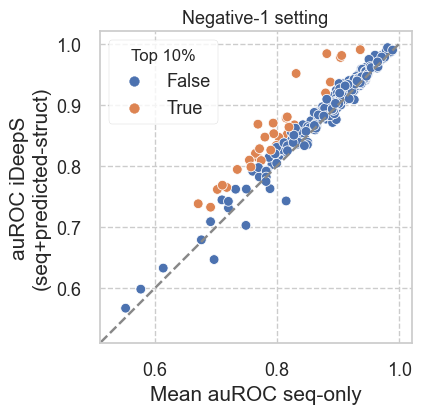

In [25]:
panel_name = "m"

if export_plots:
    savefig_file = str(Path(path_output_dir) / f"fig3_panel_{panel_name}.{{EXT}}")
else:
    savefig_file = None


fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)


sns.scatterplot(
    data=ideeps_tmp_inputfeat_n1_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile",
    ax=ax1,
)
ax1.set_title("Negative-1 setting")
ax1.set_ylabel("auROC iDeepS\n(seq+predicted-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10%")

ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")


# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)

ax1.set_aspect("equal")

ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)

fig.subplots_adjust(left=0.23, bottom=0.15)


if savefig_file:
    my_savefig(savefig_file)


plt.show()


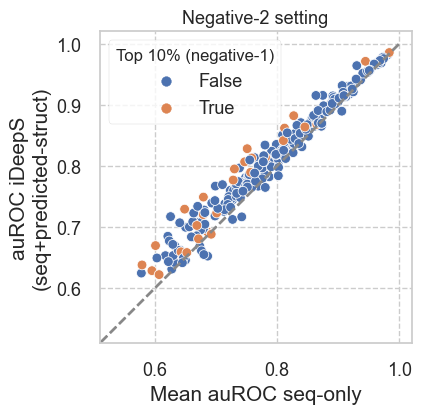

In [26]:
panel_name = "n"

if export_plots:
    savefig_file = str(Path(path_output_dir) / f"fig3_panel_{panel_name}.{{EXT}}")
else:
    savefig_file = None


fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=ideeps_tmp_inputfeat_n2_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile_n1",
    ax=ax1,
)

ax1.set_title("Negative-2 setting")
ax1.set_ylabel("auROC iDeepS\n(seq+predicted-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10% (negative-1)")
ax1.legend_.set_title("Top 10% (negative-1)")
ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")
ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")

# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)
ax1.set_aspect("equal")
ax1.set_aspect("equal")
ax1.set_xlim(0.51, 1.02)
ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)
fig.subplots_adjust(left=0.23, bottom=0.15)


if savefig_file:
    my_savefig(savefig_file)


plt.show()


### PrismNet

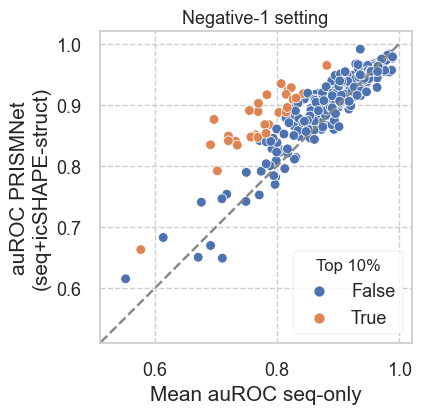

In [27]:
panel_name = "o"

if export_plots:
    savefig_file = str(Path(path_output_dir) / f"fig3_panel_{panel_name}.{{EXT}}")
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)


sns.scatterplot(
    data=prismnet_tmp_inputfeat_n1_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile",
    ax=ax1,
)
ax1.set_title("Negative-1 setting")
ax1.set_ylabel("auROC PRISMNet\n(seq+icSHAPE-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10%")

ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")


# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)

ax1.set_aspect("equal")

ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)

fig.subplots_adjust(left=0.23, bottom=0.15)


if savefig_file:
    my_savefig(savefig_file)


plt.show()


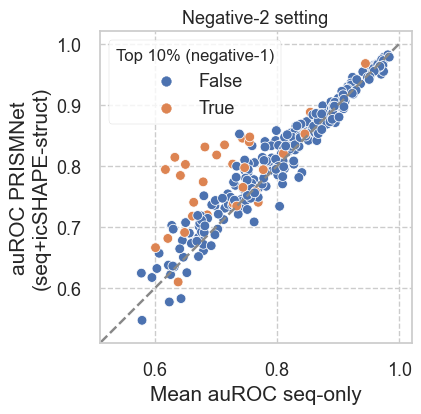

In [28]:
# PRISMNET
panel_name = "p"

if export_plots:
    savefig_file = str(Path(path_output_dir) / f"fig3_panel_{panel_name}.{{EXT}}")
else:
    savefig_file = None


fig = plt.figure(figsize=[v * 3 for v in FIG3_PANEL_SIZES["f"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=prismnet_tmp_inputfeat_n2_piv_ALT,
    x="seq",
    y="seq+struct",
    hue="is_top_decile_n1",
    ax=ax1,
)

ax1.set_title("Negative-2 setting")
ax1.set_ylabel("auROC PRISMNet\n(seq+icSHAPE-struct)")
ax1.set_xlabel("Mean auROC seq-only")

ax1.legend_.set_title("Top 10% (negative-1)")

ax1.plot([0, 1], [0, 1], linestyle="--", color="#888888")

# Fit average and plot std
# ax1 = plot_avg_std(tmp_inputfeat_rank_n1_piv['seq'], tmp_inputfeat_rank_n1_piv['seq+struct'], ax1)

ax1.set_aspect("equal")

ax1.set_xlim(0.51, 1.02)
ax1.set_ylim(0.51, 1.02)

fig.subplots_adjust(left=0.23, bottom=0.15)


if savefig_file:
    my_savefig(savefig_file)


plt.show()
